### This is a product of machine learning

In [12]:
import torch
import torch.nn as nn
import snntorch as snn

In [13]:
class SpikeRecord:
    def __init__(self):
        self.data = []

    def add_spike_data(self, spike_data):
        self.data.append(spike_data.detach())

    def get_size(self):
        if self.data:
            return torch.stack(self.data).size()
        else:
            return (0,)

    def visualize(self):
        spike_tensor = torch.stack(self.data)
        ani = tonic.utils.plot_animation(spike_tensor[:,0])
        return HTML(ani.to_jshtml())

    def clear_data(self):
        self.data = []

In [29]:
class FullyConnected2DLayer(nn.Module):
    def __init__(self, input_size, output_size, sparsity_index):
        super(FullyConnected2DLayer, self).__init__()
        self.input_size = input_size[0] * input_size[1]
        self.output_size_flat = output_size[0] * output_size[1]  # Flattened size
        self.output_size = output_size  # 2D output size
        self.weights = nn.Parameter(torch.randn(self.output_size_flat, self.input_size))
        self.sparsify_myself(sparsity_index)

    def forward(self, input):
        # Assuming input is of shape (batch_size, height, width)
        batch_size, height, width = input.shape
        flat_input = input.view(batch_size, self.input_size)
        flat_output = torch.matmul(flat_input, self.weights.t())
        output = flat_output.view(batch_size, *self.output_size)  # Use the 2D output size
        return output

    def sparsify_myself(self, sparsity_index):
        with torch.no_grad():
            mask = torch.bernoulli(torch.full(self.weights.size(), sparsity_index))
            self.weights.data.mul_(mask)
            # Rescale the weights to keep the variance stable, sqrt() expects a scalar if sparsity_index is a scalar
            self.weights.data.div_(torch.sqrt(torch.tensor(sparsity_index)))
            
class SpatialSNN(nn.Module):
    def __init__(self, sparsity_index, threshold):
        super(SpatialSNN, self).__init__()
        self.input_output_size = (64,64)

        # Initialize separate pathways with sparsity
        self.fc2d_on = FullyConnected2DLayer(self.input_output_size, self.input_output_size, sparsity_index)
        self.fc2d_off = FullyConnected2DLayer(self.input_output_size, self.input_output_size, sparsity_index)
        
        # Leaky integrate-and-fire neurons for ON and OFF pathways
        self.lif_on = snn.Leaky(beta=0.5, threshold=threshold)
        self.lif_off = snn.Leaky(beta=0.5, threshold=threshold)

        # Combined fully connected layer after ON and OFF pathways
        self.fc2d_1 = FullyConnected2DLayer(self.input_output_size, self.input_output_size, sparsity_index)
        self.lif1 = snn.Leaky(beta=0.5, threshold=threshold)

        # Final fully connected layer
        self.fc2d_2 = FullyConnected2DLayer(self.input_output_size, self.input_output_size, sparsity_index)
        self.lif2 = snn.Leaky(beta=0.5, threshold=threshold)

        # Initialize lists to record spikes
        self.spike_records_on = SpikeRecord()
        self.spike_records_off = SpikeRecord()
        self.spike_records_layer1 = SpikeRecord()
        self.spike_records_layer2 = SpikeRecord()
        
    def forward(self, input_sequence_on, input_sequence_off):
        
        self.mem_on = self.lif_on.init_leaky()
        self.mem_off = self.lif_off.init_leaky()
        self.mem1 = self.lif1.init_leaky()
        self.mem2 = self.lif2.init_leaky()

        for t in range(input_sequence_on.size(0)):
            # Get input for the current time step for ON and OFF events
            input_t_on = input_sequence_on[t]
            input_t_off = input_sequence_off[t]

            # ON pathway with size (BATCH_SIZE, 28,28)
            x_on = self.fc2d_on(input_t_on)
            spk_on, self.mem_on = self.lif_on(x_on, self.mem_on)

            # OFF pathway
            x_off = self.fc2d_off(input_t_off)
            spk_off, self.mem_off = self.lif_off(x_off, self.mem_off)
            # Combine the ON and OFF spikes
            combined_spk = torch.add(spk_on, spk_off)
            # First combined layer
            x = self.fc2d_1(combined_spk)
            spk1, self.mem1 = self.lif1(x, self.mem1)

            # Second layer
            x = self.fc2d_2(spk1)
            spk2, self.mem2 = self.lif2(x, self.mem2)
            self.spike_records_on.add_spike_data(spk_on)
            self.spike_records_off.add_spike_data(spk_off)
            self.spike_records_layer1.add_spike_data(spk1)
            self.spike_records_layer2.add_spike_data(spk2)
        
        
        # Stack the recorded spikes

        return self.spike_records_on, self.spike_records_off, self.spike_records_layer1, self.spike_records_layer2
    
sparsity_index = 0.0001  # that's a lot of sparse
threshold_model = SpatialSNN(sparsity_index, threshold=1.0)
allpass_model = SpatialSNN(sparsity_index, threshold=0.0)

torch.Size([199, 8, 2, 64, 64])


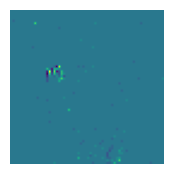

In [30]:
import random
from torch.utils.data import DataLoader, Subset
import tonic
import tonic.transforms as transforms
from tonic import datasets
from tonic import DiskCachedDataset
from IPython.display import HTML

# Load the dataset
dataset = datasets.DVSGesture(save_to='./data', train=True)
sensor_size = datasets.DVSGesture.sensor_size

# Define frame transformation
frame_transform = transforms.Compose([
    transforms.CropTime(max=2_000_000),
    transforms.Downsample(spatial_factor=0.25),  # Make sure this downsamples to (32, 32)
    transforms.ToFrame(sensor_size=(32, 32), time_window=10_000)
])

# Load the train and test datasets with the specified transformations
trainset = datasets.DVSGesture(save_to='./data', transform=frame_transform, train=True)
testset = datasets.DVSGesture(save_to='./data', transform=frame_transform, train=False)

# Subsampling parameters
batch_size = 8
subsample_percent = 10

# Subsample datasets
train_subsample_idx = random.sample(range(len(trainset)), int(len(trainset) * subsample_percent // 100))
test_subsample_idx = random.sample(range(len(testset)), int(len(testset) * subsample_percent // 100))
trainset = Subset(trainset, train_subsample_idx)
testset = Subset(testset, test_subsample_idx)

# Cache datasets
cached_trainset = DiskCachedDataset(trainset, cache_path='./cache/DVSGesture/train')
cached_testset = DiskCachedDataset(testset, cache_path='./cache/DVSGesture/test')

# DataLoader
train_loader = DataLoader(cached_trainset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(batch_first=True), shuffle=True)
test_loader = DataLoader(cached_testset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(batch_first=True))

# Retrieve a batch of frames and move time to the first dimension
frames, targets = next(iter(train_loader))
frames = frames.movedim(0, 1)

# Check the shape of the frames to ensure they are correct
print(frames.shape)
ani = tonic.utils.plot_animation(frames[:,0])
HTML(ani.to_jshtml())

In [31]:
on_A, off_A, layer1_A, layer2_A = threshold_model(frames[:,:,0], frames[:,:,1])
on_B, off_B, layer1_B, layer2_B = allpass_model(frames[:,:,0], frames[:,:,1])

In [40]:
frames = torch.stack(layer1_B.data)
expanded_frames = torch.cat((frames.unsqueeze(2), torch.zeros_like(frames).unsqueeze(2)), dim=2)
expanded_frames.shape

torch.Size([199, 8, 2, 64, 64])

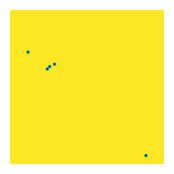

In [41]:
import matplotlib.pyplot as plt
ani = tonic.utils.plot_animation(expanded_frames[:,0])
HTML(ani.to_jshtml())

In [132]:
print([attr for attr in dir(model) if 'record' in attr])

['spike_records_layer1', 'spike_records_layer2', 'spike_records_off', 'spike_records_on']


In [118]:
#TL;DR this box loads the dataset events
dataset = tonic.datasets.DVSGesture(save_to='./data',
                               train=True)
events, _ = dataset[8]
sensor_size = tonic.datasets.DVSGesture.sensor_size

frame_transform = transforms.Compose([transforms.CropTime(max=2_000_000),
                                      transforms.Downsample(spatial_factor=0.125),
                                      transforms.ToFrame(sensor_size=(32,32),
                                                         time_window=10_000) ])

trainset = tonic.datasets.DVSGesture(save_to='./data', transform=frame_transform, train=True)
testset = tonic.datasets.DVSGesture(save_to='./data', transform=frame_transform, train=False)

batch_size = 8

subsample_percent = 10

################# DELETE IF USING WHOLE SET
train_subsample_idx = random.sample(range(0, len(trainset)), int(len(trainset)*subsample_percent//100))
test_subsample_idx = random.sample(range(0, len(testset)), int(len(testset)*subsample_percent//100))
trainset = Subset(trainset,  train_subsample_idx)
testset = Subset(testset,  test_subsample_idx)
##########################################

cached_trainset = DiskCachedDataset(trainset, cache_path='./cache/DVSGesture/train')
cached_testset = DiskCachedDataset(testset, cache_path='./cache/DVSGesture/test')

cached_dataloader = DataLoader(cached_trainset, batch_size=batch_size)
train_loader = DataLoader(cached_trainset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(batch_first=True), shuffle=True)
test_loader = DataLoader(cached_testset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(batch_first=True))
frames, targets = next(iter(train_loader))
frames = frames.movedim(0,1)

ModuleNotFoundError: No module named 'tonic.dataset_utils'

In [117]:
frames.shape

torch.Size([199, 8, 2, 64, 64])

In [ ]:

input_sequence = torch.randn(50, 8, 2, 28, 28)
out = model(input_sequence[:,:,0], input_sequence[:,:,1])

In [ ]:

class SpatialSNN(nn.Module):
    def __init__(self):
        super(SpatialSNN, self).__init__()
        # Define the size of the input and output for the layers
        self.input_output_size = (28, 28)
        
        # Two separate fully connected 2D layers
        self.fc2d_1 = FullyConnected2DLayer(self.input_output_size, self.input_output_size)
        self.lif1 = snn.Leaky()
        self.fc2d_2 = FullyConnected2DLayer(self.input_output_size, self.input_output_size)
        self.lif2 = snn.Leaky()

        # Initialize lists to record spikes - will be overwritten each forward pass
        self.spike_records_layer1 = []
        self.spike_records_layer2 = []

    def forward(self, input_sequence):
        mem1 = mem2 = None

        # Process each time step
        for t in range(input_sequence.size(0)):
            # Get input for the current time step
            input_t = input_sequence[t]

            # First layer
            x = self.fc2d_1(input_t)
            spk1, mem1 = self.lif1(x, mem1)
            self.spike_records_layer1.append(spk1.detach())

            # Second layer
            x = self.fc2d_2(spk1)
            spk2, mem2 = self.lif2(x, mem2)
            self.spike_records_layer2.append(spk2.detach())

        # Stack the recorded spikes
        self.spike_records_layer1 = torch.stack(self.spike_records_layer1, dim=0)
        self.spike_records_layer2 = torch.stack(self.spike_records_layer2, dim=0)

        # Return the final spikes and membrane potentials
        return self.spike_records_layer1, mem1, self.spike_records_layer2, mem2

In [ ]:
# Instantiate the network
model = SpatialSNN()

# Prepare input, assume spike_input is [time, batch, 28, 28]
spike_input = torch.rand(199, 1, 28, 28)  # Example input with time dimension

# Run the forward pass to process the entire sequence
spikes_layer1, mem1, spikes_layer2, mem2 = model(spike_input)

# Access the spike recordings
spike_records_layer1 = model.spike_records_layer1.cpu().numpy()
spike_records_layer2 = model.spike_records_layer2.cpu().numpy()

# The spike_records_layer1 and spike_records_layer2 have shape [time, batch, 28, 28]


In [ ]:
import torch

class Net(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size, sparsity_index):
        super(Net, self).__init__()
        
        self.ON_event_pathway = torch.nn.Sequential( snn.Leaky(beta=0.5, threshold=1),
                                                # Other layers specific to ON pathway
                                            )
        self.OFF_event_pathway = torch.nn.Sequential( snn.Leaky(beta=0.5, threshold=1),
                                                # Other layers specific to ON pathway
                                            )
        
        self.fc1 = torch.nn.Linear(hidden_size, output_size)
        self.ON_membrane_state = self.ON_event_pathway.init_leaky(batch_size=8)
        self.OFF_membrane_state = self.OFF_event_pathway.init_leaky(batch_size=8)
        
        self.spike_records = []
        # Uncomment to add layer
        # self.fc1 = torch.nn.Linear(hidden_size, hidden_size)
        # self.fc2 = torch.nn.Linear(hidden_size, output_size)
        # self.sparsify_layer(self.fc2, sparsity_index)
        
        # Custom weight initialization with sparsity
        self.sparsify_layer(self.ON_event_pathway, sparsity_index)
        self.sparsify_layer(self.OFF_event_pathway, sparsity_index)
        self.sparsify_layer(self.fc1, sparsity_index)
        
    def forward(self, on_spikes, off_spikes):
        for t in range(on_spikes.size(0)):
            # Get input for the current time step
            input_t = spike_input[t].unsqueeze(0)  # Add a batch dimension if necessary

            # Forward pass through the network
            spk_out, mem_states = model(input_t, mem_states)

            # Record the spikes; spk_out is a tensor with spikes (1's) at firing times
            spike_records.append(spk_out.detach().cpu().numpy())

    # Convert list of arrays into a numpy array for easier analysis
    spike_records = np.stack(spike_records, axis=0)

            # Forward pass through the network
            on_spikes = self.ON_event_pathway(on_spikes)
            off_spikes = self.OFF_event_pathway(off_spikes)

            #after passing ON and OFF spikes thru the first layer they are merged
            on_spikes = self.ON_event_pathway(on_spikes)
            off_spikes = self.OFF_event_pathway(off_spikes)
            out = self.fc1(on_spikes+off_spikes)
            # out = self.fc2(out) #If fc2 present
        return out
        
    def _sparsify_layer(self, unsparse_layer, sparsity_index):
        """Custom weight initializer for sparse connections."""
        with torch.no_grad():
            mask = torch.bernoulli(torch.full(unsparse_layer.weight.size(), sparsity_index))
            unsparse_layer.weight.data.mul_(mask)
            
            # Optionally, you could also re-scale the weights to keep the variance stable
            layer.weight.data.div_(torch.sqrt(sparsity_index))

# Parameters for the network
input_size = 32*32  # For a 32x32 input layer
hidden_size = 32*32 # For a 32x32 hidden layer
output_size = 10   # Example output size
sparsity_index = 0.10     # Percentage of possible connections between layers that are nonzero

# Initialize the network
net = Net(input_size, hidden_size, output_size, sparsity_index)

In [ ]:
import snntorch as snn
from snntorch import spikegen
import torch

# Define network architecture
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # Separate pathways for ON and OFF events
        self.on_pathway = torch.nn.Sequential(
            snn.Leaky(beta=0.5, threshold=1),
            # Other layers specific to ON pathway
        )
        self.off_pathway = torch.nn.Sequential(
            snn.Leaky(beta=0.5, threshold=1),
            # Other layers specific to OFF pathway
        )

        # Convergence of ON and OFF pathways
        self.converge_layer = torch.nn.Linear(2 * num_hidden_units, num_converged_units)
        self.output_layer = snn.Leaky(beta=0.5, threshold=1)

    def forward(self, on_spikes, off_spikes):
        # Forward pass through ON pathway
        for layer in self.on_pathway:
            on_mem, on_spikes = layer(on_spikes)

        # Forward pass through OFF pathway
        for layer in self.off_pathway:
            off_mem, off_spikes = layer(off_spikes)

        # Merge the ON and OFF pathways
        merged_spikes = torch.cat([on_spikes, off_spikes], dim=-1)

        # Pass merged spikes through convergence layer
        converged_mem, converged_spike = self.output_layer(self.converge_layer(merged_spikes))

        return converged_mem, converged_spike

# Initialize the network
num_inputs = 32 * 32  # Adjust based on your input size
num_hidden_units = 100  # Example size for hidden layers in ON and OFF pathways
num_converged_units = 50  # Example size for converged layer
net = Net()

In [56]:
class SpikeAnimation():
    def __init__(self, num_plots, color_map = 'coolwarm', frames = None):
        self.to_plot = []
        self.sizes = []
        self.ims = []
        self.color_map = color_map
        self.calc_frames = True
        self.fig, self.axs = plt.subplots(1, num_plots)
        if frames is not None:
            self.frames = frames
            self.calc_frames = False
        return
            
                       
    def add_to_plot(self, three_dim_tensor, size, title):
        assert len(three_dim_tensor.shape) == 3, "Not a three dimensional tensor"
        self.to_plot.append(three_dim_tensor.squeeze(1).detach().numpy())
        self.axs[len(self.to_plot)-1].set_title(title)
        self.sizes.append(size)
        self.ims.append( self.axs[len(self.to_plot)-1].imshow(self.to_plot[-1][0].reshape(size), 
                                      cmap = self.color_map) )
        return
        
    def blit(self, n):
        for iii, image in enumerate(self.ims):
            image.set_array(self.to_plot[iii][n].reshape(self.sizes[iii]))
        return self.ims
    
    def show(self, return_obj=False):
        assert len(self.to_plot) != 0, "No spikes loaded"
        ani = matplotlib.animation.FuncAnimation(self.fig, self.blit, frames = self.frames)
        if return_obj:
            return ani
        return HTML(ani.to_jshtml())

def quick_animate(three_dim_tensor, frames, titles=None, return_obj=False,):
    temp = SpikeAnimation(max(2, len(three_dim_tensor)), frames=frames)
    titles = [" "]*len(three_dim_tensor) if titles is None else titles
    for count, iii in enumerate(three_dim_tensor):
        temp.add_to_plot(iii.cpu(), (iii.shape[-1], iii.shape[-2]), f"{titles[count]}")
    return temp.show(return_obj)

def add_to_class(Class):
    """Register functions as methods in created class."""
    def wrapper(obj):
        setattr(Class, obj.__name__, obj)
    return wrapper

def pos_neg_to_frame(loader_tensor):
    # combine positive and negative channels of neuromorphic dataset
    return (loader_tensor[:,:,1]-loader_tensor[:,:,0]).movedim(0,1).unsqueeze(2)

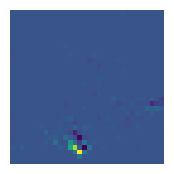

In [57]:
#TL;DR this box loads the dataset events
dataset = tonic.datasets.DVSGesture(save_to='./data',
                               train=True)
events, _ = dataset[8]
sensor_size = tonic.datasets.DVSGesture.sensor_size

frame_transform = transforms.Compose([transforms.CropTime(max=2_000_000),
                                      transforms.Downsample(spatial_factor=0.25),
                                      transforms.ToFrame(sensor_size=(32,32,2),
                                                         time_window=10_000) ])

trainset = tonic.datasets.DVSGesture(save_to='./data', transform=frame_transform, train=True)
testset = tonic.datasets.DVSGesture(save_to='./data', transform=frame_transform, train=False)

batch_size = 8

subsample_percent = 10

################# DELETE IF USING WHOLE SET
train_subsample_idx = random.sample(range(0, len(trainset)), int(len(trainset)*subsample_percent//100))
test_subsample_idx = random.sample(range(0, len(testset)), int(len(testset)*subsample_percent//100))
trainset = Subset(trainset,  train_subsample_idx)
testset = Subset(testset,  test_subsample_idx)
##########################################

cached_trainset = DiskCachedDataset(trainset, cache_path='./cache/DVSGesture/train')
cached_testset = DiskCachedDataset(testset, cache_path='./cache/DVSGesture/test')

cached_dataloader = DataLoader(cached_trainset, batch_size=batch_size)
train_loader = DataLoader(cached_trainset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(batch_first=True), shuffle=True)
test_loader = DataLoader(cached_testset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(batch_first=True))
frames, targets = next(iter(train_loader))

In [58]:

y.shape

frames = frame_transform(events)
ani = tonic.utils.plot_animation(frames)
HTML(ani.to_jshtml())

torch.Size([8, 199, 2, 64, 64])

In [128]:
frames[:,0,0].shape

torch.Size([199, 64, 64])

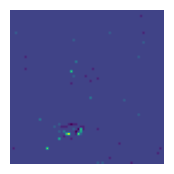

In [129]:
ani = tonic.utils.plot_animation(frames[:,0])
HTML(ani.to_jshtml())